In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Get features and outputs from Simulations

In [3]:
def get_features_and_outputs_from_simulations(output_name, timestamp):
    """
    Reads the simulation parameter map, fetches Cassandra to obtain the correspoding output for the specified timestamp.
    Splits the data into train/test sets with, returns c3.Dataset for each one of them.
    
    
    Inputs:
    - str output_name: name of the variable in SimulationModelOutput under investigation
    - str timestamp: shape of the timestamp to fetch the timeseries, e.g. "2017-08-19T09:00:00.000"
    
    Returns:
    - c3.Dataset X_train: train set of features
    - c3.Dataset X_test: test set of features
    - c3.Dataset y_train: train set of outputs
    - c3.Dataset y_test: test set of outputs

    """
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    # fetch simulation parameters
    parameters = c3.SimulationModelParameters.fetch().objs
    parameters = parameters.toJson()
    df = pd.DataFrame(parameters)
    simulations = pd.DataFrame(df['id'])
    X = df[df.columns[5:]]
    
    # define simple metric
    metric_name = "Average_" + output_name + "_SimulationSample" 
    metric_descr = "Calculates average of " + output_name + " for a given set of SimulationSample"
    metric_expr = "avg(avg(normalized.data." + output_name + "))"
    metric = c3.SimpleMetric(id = metric_name,
                                    name = metric_name,
                                    description = metric_descr,
                                    srcType = "SimulationSample",
                                    path = "output",  # the timeseries is in the output field of SimSam
                                    expression = metric_expr
                                  )
    
    # define metric spec
    spec = c3.EvalMetricsSpec(
                                    ids = simulations['id'],
                                    expressions = [metric_name],
                                    start = timestamp,
                                    end = timestamp,
                                    interval = "SECOND" 
                                )

    # evaluate metric, cast it to pandas
    evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                                        spec=spec,
                                                                        overrideMetrics=[metric]
                                                                    )
    y = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)
    
    
    # split into train/test sets
    datasets = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # cast into c3 Datasets
    X_train = c3.Dataset.fromPython(datasets[0])
    X_test = c3.Dataset.fromPython(datasets[1])
    y_train = c3.Dataset.fromPython(datasets[2])
    y_test = c3.Dataset.fromPython(datasets[3])
    
    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = get_features_and_outputs_from_simulations("mass_BC_acc", "2017-08-19T09:00:00.000")

# Principal Component Analysis

In [43]:
pca = c3.SklearnPipe(
                        name="pca",
                        technique=c3.SklearnTechnique(
                                                        name="decomposition.PCA",
                                                        processingFunctionName="transform",
                                                        hyperParameters={
                                                                            "n_components": 30,
                                                                            "random_state": 42
                                                        }
                        )
)

In [44]:
gaussianRegression = c3.SklearnPipe(
                        name="gaussianRegression",
                        technique=c3.SklearnTechnique(
                            name="gaussian_process.GaussianProcessRegressor",
                            processingFunctionName="predict",
                            hyperParameters={
                                                'alpha': 1e-10,
                                                'copy_X_train': True,
                                                'kernel': None,
                                                'n_restarts_optimizer': 0,
                                                'normalize_y': True,
                                                'optimizer': 'fmin_l_bfgs_b',
                                                'random_state': None}
                            )
                    )

In [45]:
grPipeline = c3.MLSerialPipeline(
                name="grPipeline",
                steps=[
                        c3.MLStep(name="pca",
                                 pipe=pca),
                       c3.MLStep(name="gaussianRegression",
                                 pipe=gaussianRegression)
                        ],
                scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLRSquaredMetric()])
             )

In [53]:
trainedGr = grPipeline.train(input=X_train, targetOutput=y_train)

In [47]:
scoreGr = trainedGr.score(input=X_test, targetOutput=y_test)
scoreGr

c3.Mapp<string, double>({'MLRSquaredMetric': 0.3313904761738715})

### Run over PCA n_components

In [54]:
# check current hyper parameters
trainedGr.hyperParams()

c3.Mapp<string, any>({'gaussianRegression__alpha': 1e-10,
 'gaussianRegression__copy_X_train': True,
 'gaussianRegression__kernel': None,
 'gaussianRegression__n_restarts_optimizer': 0.0,
 'gaussianRegression__normalize_y': True,
 'gaussianRegression__optimizer': 'fmin_l_bfgs_b',
 'gaussianRegression__random_state': None,
 'pca__n_components': 30.0,
 'pca__random_state': 42.0})

In [62]:
ncomps = []
scores = []
for nc in range(1,60):
    # insert new n_components
    grPipeline = grPipeline.withHyperParams({
        "pca__n_components": nc
    })
    # train
    trainedGr = grPipeline.train(input=X_train, targetOutput=y_train)
    # score
    scoreGr = trainedGr.score(input=X_test, targetOutput=y_test)
    print('PCA n_components: ', nc, '  Score on test:', scoreGr)
    ncomps.append(nc)
    scores.append(scoreGr['MLRSquaredMetric'])

PCA n_components:  1   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -0.12545918951155755})
PCA n_components:  2   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -1.2045954202718216})
PCA n_components:  3   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -23.821793744478757})
PCA n_components:  4   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -33.266060211877615})
PCA n_components:  5   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -3.775804756169821})
PCA n_components:  6   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -7.662345897440801})
PCA n_components:  7   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -4.972937864957904})
PCA n_components:  8   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -2.9667158012063743})
PCA n_components:  9   Score on test: c3.Mapp<string, double>({'MLRSquaredMetric': -2.5392403240910792})
PCA n_components:  10   Score on test: c3.Mapp<string, do

(-1.0, 0.5)

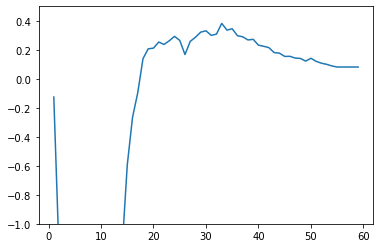

In [65]:
plt.figure()
plt.plot(ncomps, scores)
plt.ylim(-1,0.5)

In [ ]:
EvalMetricsNdArraySourceSpec
source_spec.toStream().collectAndMerge().toPandas()